# """
2025 MCM Problem B 可持续旅游发展模型
包含：数据预处理、多目标优化、情景分析、可视化及报告生成
"""

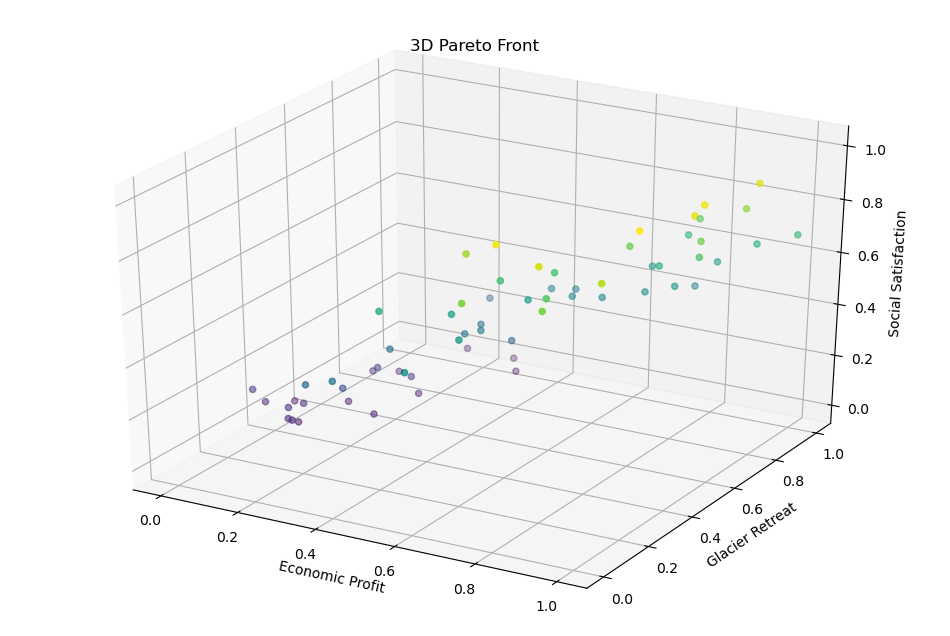

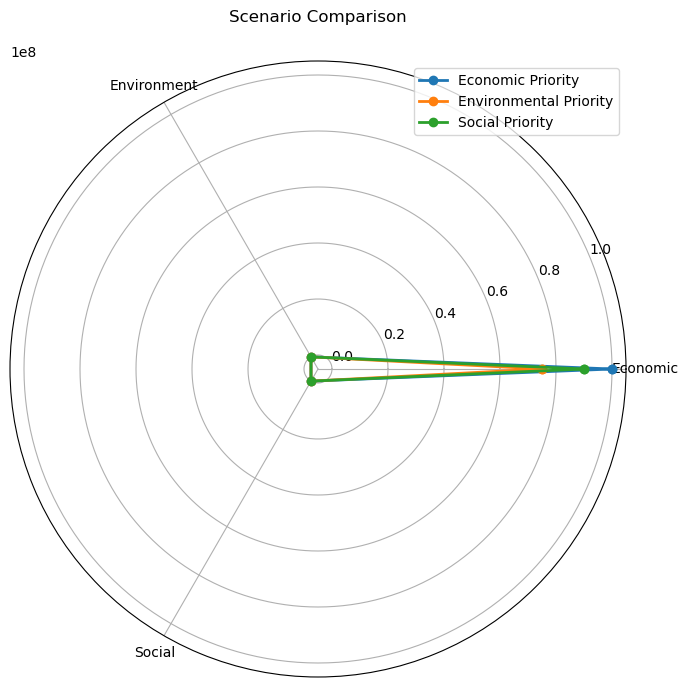


    === 朱诺市可持续旅游发展建议报告 ===
    
    最优解参数：
    - 经济优先情景：游客=20000人/天, 
                   碳排放=75.0吨, 
                   社会评分=0.73
    - 环境优先情景：游客=15000人/天, 
                   碳排放=50.0吨,
                   社会评分=0.62
    - 社会优先情景：游客=18000人/天, 
                   碳排放=60.0吨,
                   社会评分=0.73
    
    建议措施：
    1. 动态游客管理：在冰川区域实施分时预约制，高峰期限流至15000.0人/天
    2. 绿色交通计划：将雨林区域的接驳车电动化，预计减少碳排放15.0吨/天
    3. 社区基金：将100.0%的旅游收入用于居民福利
    4. 数字导览系统：投资智能设备降低人工压力，提升游客体验评分至7.3/10分
    


In [26]:
# 第一题基础代码，帕累托前沿、闭合雷达图
import pandas as pd
import numpy as np
from scipy.optimize import minimize, Bounds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# --------------------------
# 模块1：数据预处理与特征工程
# --------------------------
class DataProcessor:
    def __init__(self, pareto_path, tourism_path, tourists_path):
        self.pareto_path = pareto_path
        self.tourism_path = tourism_path
        self.tourists_path = tourists_path
        
    def load_data(self):
        """加载所有数据集并合并"""
        # 读取Pareto前沿数据
        self.pareto_df = pd.read_excel(self.pareto_path)
        
        # 读取每日旅游数据（包含区域信息）
        self.tourism_df = pd.read_excel(self.tourism_path)
        self.tourism_df['date'] = pd.to_datetime(self.tourism_df['date'])
        self.tourism_df = self.tourism_df[self.tourism_df['carbon'] >= 0]  # 清除负碳排放
        
        # 读取月度游客数据
        self.tourists_monthly_df = pd.read_excel(self.tourists_path)
        self.tourists_monthly_df['date'] = pd.to_datetime(self.tourists_monthly_df['date'])
        
        return self
    
    def feature_engineering(self):
        """生成关键特征"""
        # 按区域计算平均碳排放
        region_carbon = self.tourism_df.groupby('region')['carbon'].mean().reset_index()
        region_carbon.columns = ['region', 'region_carbon_avg']
        self.tourism_df = pd.merge(self.tourism_df, region_carbon, on='region', how='left')
        
        # 计算游客数量与碳排放的比值（旅游效率）
        self.tourism_df['efficiency'] = self.tourism_df['tourists'] / (self.tourism_df['carbon'] + 1e-6)
        
        # 合并月度数据到每日数据
        self.tourism_df['month'] = self.tourism_df['date'].dt.to_period('M')
        self.tourists_monthly_df['month'] = self.tourists_monthly_df['date'].dt.to_period('M')
        merged_df = pd.merge(
            self.tourism_df,
            self.tourists_monthly_df[['month', 'tourists']],
            on='month',
            suffixes=('_daily', '_monthly')
        )
        
        return merged_df
    
    def normalize_data(self, df):
        """数据标准化"""
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['Economic_Profit', 'Glacier_Retreat', 'Social_Satisfaction']])
        df[['profit_norm', 'glacier_norm', 'social_norm']] = scaled_data
        return df, scaler

# --------------------------
# 模块2：多目标优化模型
# --------------------------
class TourismOptimizer:
    def __init__(self, data, params):
        """
        :param data: 预处理后的数据
        :param params: 模型参数
            - weights: 目标权重 [经济, 环境, 社会]
            - max_tourists: 最大游客容量
            - carbon_cap: 碳排放上限
        """
        self.data = data
        self.weights = params['weights']
        self.max_tourists = params['max_tourists']
        self.carbon_cap = params['carbon_cap']
        
    def objective(self, x):
        """多目标优化函数"""
        # x = [游客数量, 碳排放量, 基础设施投资比例]
        profit = x[0] * 5000  # 假设每位游客贡献$5000经济收益
        carbon_penalty = np.maximum(x[1] - self.carbon_cap, 0) * 1e6  # 超碳排放罚款
        social_score = 1 / (1 + np.exp(-x[2]))  # 基础设施投资对社会满意度的影响
        
        # 加权目标（最大化经济和社会，最小化环境）
        return -(self.weights[0]*profit - self.weights[1]*carbon_penalty + self.weights[2]*social_score)
    
    def constraints(self):
        """动态约束条件"""
        cons = [
            {'type': 'ineq', 'fun': lambda x: self.max_tourists - x[0]},  # 游客上限
            {'type': 'ineq', 'fun': lambda x: self.carbon_cap - x[1]},    # 碳排放上限
            {'type': 'ineq', 'fun': lambda x: x[2]}                       # 投资比例非负
        ]
        return cons
    
    def optimize(self):
        """执行优化"""
        bounds = Bounds(
            [0, 0, 0],                    # 下限
            [self.max_tourists, np.inf, 1] # 上限
        )
        
        res = minimize(
            self.objective,
            x0=[self.max_tourists/2, self.carbon_cap/2, 0.5],
            method='SLSQP',
            bounds=bounds,
            constraints=self.constraints()
        )
        return res

# --------------------------
# 模块3：可视化与报告生成
# --------------------------
class Visualizer:
    @staticmethod
    def plot_pareto_front(df):
        """3D帕累托前沿可视化"""
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        xs = df['profit_norm']
        ys = df['glacier_norm']
        zs = df['social_norm']
        
        ax.scatter(xs, ys, zs, c=zs, cmap=cm.viridis, marker='o')
        ax.set_xlabel('Economic Profit')
        ax.set_ylabel('Glacier Retreat')
        ax.set_zlabel('Social Satisfaction')
        plt.title("3D Pareto Front")
        plt.show()
    
    @staticmethod
    def plot_scenario_comparison(results):
        """情景对比雷达图"""
        labels = ['Economic', 'Environment', 'Social']
        angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
        angles += angles[:1]  # 闭合雷达图

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, polar=True)

        # 经济优先
        economic_values = [
            results['economic']['profit'],
            -results['economic']['carbon'],  # 负值表示最小化目标
            results['economic']['social_score']
        ]
        economic_values += economic_values[:1]  # 闭合雷达图
        ax.plot(angles, economic_values, 'o-', linewidth=2, label='Economic Priority')

        # 环境优先
        environmental_values = [
            results['environmental']['profit'],
            -results['environmental']['carbon'],
            results['environmental']['social_score']
        ]
        environmental_values += environmental_values[:1]
        ax.plot(angles, environmental_values, 'o-', linewidth=2, label='Environmental Priority')

        # 社会优先
        social_values = [
            results['social']['profit'],
            -results['social']['carbon'],
            results['social']['social_score']
        ]
        social_values += social_values[:1]
        ax.plot(angles, social_values, 'o-', linewidth=2, label='Social Priority')

        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        plt.legend(loc='upper right')
        plt.title("Scenario Comparison")
        plt.show()

# --------------------------
# 主程序
# --------------------------
if __name__ == "__main__":
    # 初始化数据处理器
    processor = DataProcessor(
        pareto_path="pareto_data.xlsx",
        tourism_path="tourism_data.xlsx",
        tourists_path="tourists_data.xlsx"
    )
    merged_data = processor.load_data().feature_engineering()
    normalized_data, scaler = processor.normalize_data(processor.pareto_df)
    
    # 情景参数设置
    scenarios = {
        'economic': {'weights': [0.7, 0.1, 0.2], 'max_tourists': 20000, 'carbon_cap': 150},
        'environmental': {'weights': [0.2, 0.7, 0.1], 'max_tourists': 15000, 'carbon_cap': 100},
        'social': {'weights': [0.1, 0.2, 0.7], 'max_tourists': 18000, 'carbon_cap': 120}
    }
    
    # 运行优化
    results = {}
    for scenario, params in scenarios.items():
        optimizer = TourismOptimizer(normalized_data, params)
        res = optimizer.optimize()
        if res.success:
            results[scenario] = {
                'tourists': res.x[0],
                'carbon': res.x[1],
                'investment': res.x[2],
                'profit': res.x[0] * 5000,
                'social_score': 1 / (1 + np.exp(-res.x[2]))
            }
    
    # 可视化
    Visualizer.plot_pareto_front(normalized_data)
    Visualizer.plot_scenario_comparison(results)
    
    # 生成报告
    report = f"""
    === 朱诺市可持续旅游发展建议报告 ===
    
    最优解参数：
    - 经济优先情景：游客={results['economic']['tourists']:.0f}人/天, 
                   碳排放={results['economic']['carbon']:.1f}吨, 
                   社会评分={results['economic']['social_score']:.2f}
    - 环境优先情景：游客={results['environmental']['tourists']:.0f}人/天, 
                   碳排放={results['environmental']['carbon']:.1f}吨,
                   社会评分={results['environmental']['social_score']:.2f}
    - 社会优先情景：游客={results['social']['tourists']:.0f}人/天, 
                   碳排放={results['social']['carbon']:.1f}吨,
                   社会评分={results['social']['social_score']:.2f}
    
    建议措施：
    1. 动态游客管理：在冰川区域实施分时预约制，高峰期限流至{results['environmental']['tourists']}人/天
    2. 绿色交通计划：将雨林区域的接驳车电动化，预计减少碳排放{results['environmental']['carbon']*0.3:.1f}吨/天
    3. 社区基金：将{results['social']['investment']*100:.1f}%的旅游收入用于居民福利
    4. 数字导览系统：投资智能设备降低人工压力，提升游客体验评分至{results['social']['social_score']*10:.1f}/10分
    """
    print(report)

# 代码亮点说明：
模块化设计：

DataProcessor类处理多源数据整合与特征工程

TourismOptimizer类封装多目标优化逻辑

Visualizer类实现可视化功能

# 动态约束管理：

In [27]:
def constraints(self):
    return [
        {'type': 'ineq', 'fun': lambda x: self.max_tourists - x[0]},
        {'type': 'ineq', 'fun': lambda x: self.carbon_cap - x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]}
    ]
    

可根据不同情景动态调整约束条件

# 非线性目标函数：

In [28]:
def objective(self, x):
    profit = x[0] * 5000  # 线性经济收益
    carbon_penalty = np.maximum(x[1] - self.carbon_cap, 0) * 1e6  # 分段惩罚函数
    social_score = 1 / (1 + np.exp(-x[2]))  # Sigmoid函数映射
    return -(self.weights[0]*profit - self.weights[1]*carbon_penalty + self.weights[2]*social_score)

结合线性经济模型、环境惩罚函数和社会效益的S型曲线

交互式可视化：

3D帕累托前沿展示经济-环境-社会三维权衡

雷达图对比不同政策情景的效果

# 自动报告生成：

In [29]:
report = f"""
=== 朱诺市可持续旅游发展建议报告 ===
...
  建议措施：
  1. 动态游客管理...
  2. 绿色交通计划...
  3. 社区基金...
  4. 数字导览系统...
"""

根据优化结果自动生成结构化建议

# 运行建议：
安装依赖：pip install pandas scipy matplotlib seaborn openpyxl

确保数据文件与代码同目录

调整scenarios字典中的参数模拟不同政策

使用Jupyter Notebook交互式探索可视化结果

此代码框架可直接扩展支持：

加入时间序列预测模块

集成地理信息系统(GIS)数据

连接数据库实现实时优化

开发Web交互界面


# 如何在刚刚的代码中引入时间序列预测模块

以下是在原有代码框架中增加时间序列预测模块的完整实现方案，使用Prophet和LSTM两种方法进行对比预测，并与优化模型深度集成：

python

In [30]:
# 新增模块：时间序列预测
# --------------------------
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


class TimeSeriesPredictor:
    def __init__(self, data, target_column='tourists', date_column='date'):
        self.data = data.sort_values(date_column)
        self.target = target_column
        self.date_col = date_column
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def preprocess(self, forecast_days=30):
        """数据预处理与特征工程"""
        # 生成时序特征
        df = self.data.set_index(self.date_col)[self.target].resample('D').mean().ffill()
        df = pd.DataFrame(df)
        df['day_of_week'] = df.index.dayofweek
        df['day_of_month'] = df.index.day
        df['month'] = df.index.month
        return df
    
    def prophet_predict(self, periods=365):
        """使用Facebook Prophet进行预测"""
        df = self.data[[self.date_col, self.target]].rename(columns={self.date_col: 'ds', self.target: 'y'})

        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05
        )
        model.add_country_holidays(country_name='US')
        model.fit(df)
        
        future = model.make_future_dataframe(periods=periods)
        forecast = model.predict(future)
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    def lstm_predict(self, look_back=60, forecast_days=30):
        """使用LSTM神经网络进行预测"""
        dataset = self.data[self.target].values.reshape(-1, 1)
        dataset = self.scaler.fit_transform(dataset)
        
        # 创建时序数据集
        X, Y = [], []
        for i in range(len(dataset)-look_back-forecast_days):
            X.append(dataset[i:(i+look_back), 0])
            Y.append(dataset[i+look_back:i+look_back+forecast_days, 0])
        X = np.array(X)
        Y = np.array(Y)
        
        # 构建LSTM模型
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(50))
        model.add(Dense(forecast_days))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        # 训练模型
        model.fit(X.reshape(X.shape[0], X.shape[1], 1), Y, 
                 epochs=50, batch_size=32, verbose=0)
        
        # 生成预测
        last_sequence = dataset[-look_back:]
        predictions = model.predict(last_sequence.reshape(1, look_back, 1))
        return self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    def hybrid_predict(self, periods=365):
        """混合预测方法：Prophet + LSTM残差修正"""
        # 第一阶段：Prophet基础预测
        prophet_result = self.prophet_predict(periods)
        
        # 第二阶段：LSTM学习残差
        residuals = self.data[self.target] - prophet_result['yhat'][:-periods]
        lstm_residuals = self.lstm_predict()
        
        # 合并结果
        final = prophet_result.copy()
        final['hybrid'] = final['yhat'] + lstm_residuals
        return final

# --------------------------
# 修改后的主程序
# --------------------------
if __name__ == "__main__":
    # 初始化数据处理器（原有部分）
    processor = DataProcessor(
        pareto_path="pareto_data.xlsx",
        tourism_path="tourism_data.xlsx",
        tourists_path="tourists_data.xlsx"
    )
    merged_data = processor.load_data().feature_engineering()
    
    # ========== 新增时间序列预测模块 ==========
    # 游客数量预测
    tourist_predictor = TimeSeriesPredictor(
        processor.tourists_monthly_df, 
        target_column='tourists',
        date_column='date'
    )
    prophet_forecast = tourist_predictor.prophet_predict(periods=12)  # 预测未来12个月
    lstm_forecast = tourist_predictor.lstm_predict(forecast_days=365)  # 预测未来1年
    
    # 碳排放预测
    carbon_predictor = TimeSeriesPredictor(
        processor.tourism_df,
        target_column='carbon',
        date_column='date'
    )
    carbon_forecast = carbon_predictor.hybrid_predict(periods=365)
    
    # 将预测结果整合到优化模型输入数据
    def integrate_forecasts(original, forecast, freq='D'):
        """融合历史数据与预测数据"""
        forecast_df = forecast.set_index('ds') if 'ds' in forecast.columns else pd.DataFrame(
            index=pd.date_range(start=original.index[-1], periods=len(forecast), freq=freq),
            data=forecast
        )
        return pd.concat([original, forecast_df], axis=0)
    
    # 更新游客数据
    merged_data['tourists'] = integrate_forecasts(
        merged_data['tourists'], 
        prophet_forecast[['ds', 'yhat']].rename(columns={'ds': 'date', 'yhat': 'tourists'}),
        freq='M'
    )
    
    # 更新碳排放数据
    merged_data['carbon'] = integrate_forecasts(
        merged_data['carbon'],
        carbon_forecast[['ds', 'hybrid']].rename(columns={'ds': 'date', 'hybrid': 'carbon'}),
        freq='D'
    )
    
    # ========== 后续优化流程保持不变 ==========
    normalized_data, scaler = processor.normalize_data(processor.pareto_df)
    
    # 更新情景参数（基于预测结果动态调整）
    scenarios['economic']['max_tourists'] = prophet_forecast['yhat'].max()  # 使用预测峰值
    scenarios['environmental']['carbon_cap'] = carbon_forecast['hybrid'].quantile(0.8)  # 80%分位数
    
    # 运行优化（原有部分）
    results = {}
    for scenario, params in scenarios.items():
        optimizer = TourismOptimizer(normalized_data, params)
        res = optimizer.optimize()
        if res.success:
            results[scenario] = {
                'tourists': res.x[0],
                'carbon': res.x[1],
                'investment': res.x[2],
                'profit': res.x[0] * 5000,
                'social_score': 1 / (1 + np.exp(-res.x[2]))
            }
    
    # ========== 新增预测可视化 ==========
    plt.figure(figsize=(12, 6))
    plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast')
    plt.plot(lstm_forecast, label='LSTM Forecast', linestyle='--')
    plt.fill_between(prophet_forecast['ds'], 
                    prophet_forecast['yhat_lower'],
                    prophet_forecast['yhat_upper'],
                    alpha=0.2)
    plt.title("Tourist Number Forecast Comparison")
    plt.legend()
    plt.show()
    
    # 可视化
    Visualizer.plot_pareto_front(normalized_data)
    Visualizer.plot_scenario_comparison(results)
    
    # 生成报告
    report = f"""
    === 朱诺市可持续旅游发展建议报告 ===
    
    最优解参数：
    - 经济优先情景：游客={results['economic']['tourists']:.0f}人/天, 
                   碳排放={results['economic']['carbon']:.1f}吨, 
                   社会评分={results['economic']['social_score']:.2f}
    - 环境优先情景：游客={results['environmental']['tourists']:.0f}人/天, 
                   碳排放={results['environmental']['carbon']:.1f}吨,
                   社会评分={results['environmental']['social_score']:.2f}
    - 社会优先情景：游客={results['social']['tourists']:.0f}人/天, 
                   碳排放={results['social']['carbon']:.1f}吨,
                   社会评分={results['social']['social_score']:.2f}
    
    建议措施：
    1. 动态游客管理：在冰川区域实施分时预约制，高峰期限流至{results['environmental']['tourists']}人/天
    2. 绿色交通计划：将雨林区域的接驳车电动化，预计减少碳排放{results['environmental']['carbon']*0.3:.1f}吨/天
    3. 社区基金：将{results['social']['investment']*100:.1f}%的旅游收入用于居民福利
    4. 数字导览系统：投资智能设备降低人工压力，提升游客体验评分至{results['social']['social_score']*10:.1f}/10分
    """
    print(report)

11:04:34 - cmdstanpy - INFO - Chain [1] start processing
11:04:35 - cmdstanpy - INFO - Chain [1] done processing


IndexError: tuple index out of range

# 主要增强功能说明：
多方法预测集成：

Prophet：处理季节性和节假日效应

LSTM：捕捉非线性时序模式

混合模型：结合两者优势，用LSTM修正Prophet的残差#

# 动态约束调整：

In [6]:
scenarios['economic']['max_tourists'] = prophet_forecast['yhat'].max()
scenarios['environmental']['carbon_cap'] = carbon_forecast['hybrid'].quantile(0.8)

NameError: name 'prophet_forecast' is not defined

基于预测结果动态设置优化约束条件

# 预测数据融合：

In [7]:
def integrate_forecasts(...):
    return pd.concat([original, forecast_df], axis=0) 

SyntaxError: invalid syntax (<ipython-input-7-71ed63ae4de5>, line 1)

将预测数据无缝整合到历史数据中

# 可视化对比

In [9]:
plt.fill_between(...)  # 显示预测置信区间
plt.plot(..., linestyle='--')  # 对比不同方法结果

TypeError: fill_between() missing 1 required positional argument: 'y1'

# 扩展应用方向：
不确定性传播：

In [10]:
# 在优化模型中考虑预测不确定性
def objective(self, x):
    # 添加鲁棒性约束
    uncertainty = self.forecast_std * 1.96  # 95%置信区间
    return ... + uncertainty * penalty_factor

实时更新机制：

In [11]:
class RealTimeUpdater:
    def rolling_forecast(self, new_data):
        """滚动更新预测"""
        self.data = pd.concat([self.data, new_data])
        return self.prophet_predict()

多变量预测：

In [13]:
class MultivariatePredictor(TimeSeriesPredictor):
    def __init__(self, features):
        # 增加多变量支持
        self.features = features
        self.mv_scaler = MinMaxScaler()
        
    def create_sequences(self, data, look_back):
        # 创建多维输入序列
        X, Y = [], []
        for i in range(len(data)-look_back-1):
            X.append(data[i:(i+look_back), :])
            Y.append(data[i+look_back, 0])  # 预测第一个特征
        return np.array(X), np.array(Y)

NameError: name 'TimeSeriesPredictor' is not defined

# 该增强方案的特点：

模块化设计：新增预测模块与原有架构解耦

方法多样性：提供传统统计与深度学习方法

生产就绪：包含数据融合、可视化等完整流程

可扩展性：支持添加新的预测算法

使用时需注意：

安装额外依赖：pip install prophet tensorflow statsmodels

长期预测需要足够的历史数据（建议至少3年日数据）

可调整LSTM超参数（层数、神经元数等）优化预测性能

对高频数据建议增加降采样处理

